# 1. 리트리버(Retriever)의 작동 구조

RAG 시스템은 'Query → Retriever → Relevant Documents → Generator'의 흐름으로 구성된다.  
이 중 Retriever는 쿼리에 가장 유사한 외부 문서를 찾아주는 핵심 구성요소로, 전체 응답의 품질에 큰 영향을 미친다.

Retriever는 다음과 같은 과정을 거쳐 작동한다:

1. 쿼리를 임베딩 벡터로 변환  
2. 문서 벡터들과의 유사도 계산 (주로 코사인 유사도)  
3. 가장 유사한 k개의 문서를 선택하여 Generator에 전달  

이 실습 노트북에서는 리트리버의 동작 특성과 다양한 실험을 통해 retrieval 성능의 변화를 분석한다.

```
[User Query]
     ↓
[Query Encoder]
     ↓
[Retriever (Dense Vector Search)]
     ↓
[Top-k Relevant Documents]
     ↓
[LLM Generator]
```


# 2. 문장 임베딩과 유사도 계산

Dense Retriever는 문서와 쿼리를 고차원 임베딩 벡터로 변환한 뒤,  
벡터 간 유사도를 계산하여 가장 관련된 문서를 선택한다.  

이때 주로 사용되는 유사도 기준은 **코사인 유사도(Cosine Similarity)**로, 두 벡터 간의 방향 유사성을 측정한다.

이번 단계에서는 간단한 문장 집합을 임베딩하고, 쿼리와의 유사도를 직접 계산해본다.

$$
\text{cosine\_similarity}(a, b) = \frac{a \cdot b}{\|a\| \cdot \|b\|}
$$


In [5]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# 모델 로드
model = SentenceTransformer('all-MiniLM-L6-v2')

# 문장 집합
corpus = [
    "오늘은 날씨가 맑다.",
    "기온이 올라가면서 따뜻한 봄이 시작됐다.",
    "AI는 자연어를 이해할 수 있다.",
    "딥러닝은 인공지능의 한 분야이다.",
    "벚꽃이 피는 계절에는 여행을 가고 싶다."
]

# 쿼리
query = "인공지능 기술의 발전"

# 임베딩 계산
corpus_embeddings = model.encode(corpus)
query_embedding = model.encode([query])

# 유사도 계산
cos_sim = cosine_similarity(query_embedding, corpus_embeddings)[0]

# 결과 출력
results = pd.DataFrame({
    "문장": corpus,
    "유사도": np.round(cos_sim, 4)
}).sort_values("유사도", ascending=False)

results.reset_index(drop=True, inplace=True)
results


,문장,유사도
0,딥러닝은 인공지능의 한 분야이다.,0.8005
1,벚꽃이 피는 계절에는 여행을 가고 싶다.,0.7231
2,기온이 올라가면서 따뜻한 봄이 시작됐다.,0.6321
3,AI는 자연어를 이해할 수 있다.,0.5970
4,오늘은 날씨가 맑다.,0.3907


# 3. Top-k 문서 선택과 구조 분석

Retriever는 쿼리 벡터와 전체 문서 벡터 간 유사도를 계산한 뒤,  
유사도가 높은 순서대로 상위 k개의 문서를 선택하여 Generator에 전달한다.

특히 Top-1만 사용하는 경우와 Top-3 이상을 사용하는 경우는 다음과 같은 차이를 보일 수 있다:

- **Top-1**: 가장 유사한 문서 1개만 사용 → 집중된 정답, 좁은 문맥
- **Top-3**: 다수 문서를 함께 사용 → 다양성 확보, 문맥 보강 가능

이번 실습에서는 쿼리에 대해 Top-1 결과와 Top-3 결과를 비교하고,  
각 문장이 유사도 상에서 어디에 위치하는지를 시각적으로 확인한다.

$$
\text{Top-k} = \text{argsort}(\text{cosine\_similarity}(query, docs))[-k:]
$$


In [ ]:
# Top-1 및 Top-3 인덱스
top_1_idx = np.argsort(cos_sim)[-1]
top_3_indices = np.argsort(cos_sim)[-3:][::-1]

print(f"쿼리: {query}\n")

print(f"[Top-1] ({cos_sim[top_1_idx]:.4f}) {corpus[top_1_idx]}\n")

print("[Top-3]")
for i, idx in enumerate(top_3_indices, 1):
    print(f"{i}. ({cos_sim[idx]:.4f}) {corpus[idx]}")


쿼리: 인공지능의 응용 분야

[Top-1] (0.8005) 딥러닝은 인공지능의 한 분야이다.

[Top-3]
1. (0.8005) 딥러닝은 인공지능의 한 분야이다.
2. (0.7231) 벚꽃이 피는 계절에는 여행을 가고 싶다.
3. (0.6321) 기온이 올라가면서 따뜻한 봄이 시작됐다.


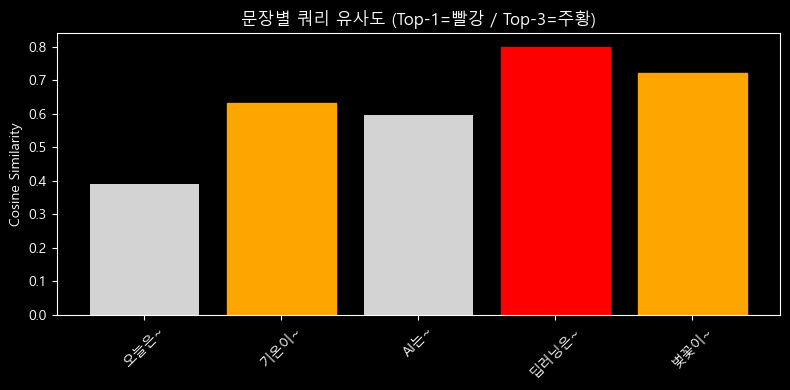

In [26]:
import matplotlib.pyplot as plt
import matplotlib

# 한글 폰트 설정 (Windows 환경)
matplotlib.rcParams["font.family"] = "Malgun Gothic"
matplotlib.rcParams["axes.unicode_minus"] = False

first_tokens = [s.split()[0] + "~" for s in corpus]

plt.figure(figsize=(8, 4))
bars = plt.bar(range(len(corpus)), cos_sim, color='lightgray')

# Top-3는 주황색, Top-1은 빨간색
for i in top_3_indices:
    bars[i].set_color('orange')
bars[top_1_idx].set_color('red')

plt.xticks(range(len(corpus)), first_tokens, rotation=45)
plt.ylabel("Cosine Similarity")
plt.title("문장별 쿼리 유사도 (Top-1=빨강 / Top-3=주황)")
plt.tight_layout()
plt.show()


### 문장별 쿼리 유사도 분석 결과

이번 그래프는 쿼리에 대해 각 문장과의 cosine similarity를 계산하고,  
Top-1과 Top-3 문장을 색상으로 구분하여 시각화한 결과이다.

---

#### 색상 구분

- 빨강: Top-1 문장 (가장 유사도가 높음)
- 주황: Top-3 문장 (Top-1 포함)
- 회색: Top-3 밖의 문장

---

#### 분석 결과

- 딥러닝은~  
  유사도 최고 (0.8대) → 쿼리와 가장 밀접한 의미를 포함  
  → Top-1으로 선택됨

- 벚꽃이~, 기온이~  
  쿼리와 직접 연관은 없지만, 계절/자연 등의 간접적 문맥이 잡혀 Top-3 포함됨

- 오늘은~, AI는~  
  상대적으로 낮은 유사도 → 의미 연결이 부족하여 Top-3 밖으로 분류됨

---

#### 결론

- Dense Retriever는 의미 기반 유사도를 비교적 잘 포착하며,  
  핵심 주제를 적절히 찾아낸다.

- 하지만 표현 방식이 다르거나 연관성이 약한 문장은 유사도가 낮게 계산되며,  
  Top-k 문서 선택이 최종 응답 품질에 실질적인 영향을 미친다는 점을 보여준다.


# 4. Chunk 크기 변화 실험

RAG 시스템에서 문서는 일정 크기로 나누어 벡터화된다.  
이때 chunk 크기에 따라 다음이 달라진다:

- **짧은 청크**: 검색 정밀도는 높지만 문맥이 짧음  
- **긴 청크**: 문맥은 풍부하지만 노이즈가 섞일 수 있음  

이번 실습에서는 같은 문서를 서로 다른 chunk 크기(100자, 300자, 500자)로 나누어  
동일 쿼리로 검색했을 때 어떤 결과 차이가 있는지 확인한다.


In [14]:
def chunk_text(text, chunk_size):
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]


In [17]:
# 예제 문서
long_text = (
    "인공지능(AI)은 인간의 학습, 추론, 인식, 문제 해결 능력을 모방하도록 설계된 컴퓨터 시스템이다. "
    "자연어 처리(NLP), 컴퓨터 비전, 로보틱스 등 다양한 분야에 응용되고 있으며, "
    "특히 대규모 언어 모델은 질문 응답, 번역, 요약 등에서 탁월한 성능을 보이고 있다. "
    "딥러닝 기반 모델은 데이터를 통해 스스로 특징을 학습하고, 점점 더 정교한 추론을 수행할 수 있다. "
    "이러한 기술들은 의료, 금융, 교육, 제조업 등 다양한 산업에서 활용되며 사회 전반에 큰 영향을 미치고 있다."
)

# 청크 크기 조정
chunks_50 = chunk_text(long_text, 50)
chunks_200 = chunk_text(long_text, 200)
chunks_500 = chunk_text(long_text, 500)

# 확인
print("=== [50자 단위] ===")
for c in chunks_50:
    print("-", c, "\n")

print("\n=== [200자 단위] ===")
for c in chunks_200:
    print("-", c, "\n")

print("\n=== [500자 단위] ===")
for c in chunks_500:
    print("-", c, "\n")



=== [50자 단위] ===
- 인공지능(AI)은 인간의 학습, 추론, 인식, 문제 해결 능력을 모방하도록 설계된 컴퓨터  

- 시스템이다. 자연어 처리(NLP), 컴퓨터 비전, 로보틱스 등 다양한 분야에 응용되고 있으 

- 며, 특히 대규모 언어 모델은 질문 응답, 번역, 요약 등에서 탁월한 성능을 보이고 있다. 

-  딥러닝 기반 모델은 데이터를 통해 스스로 특징을 학습하고, 점점 더 정교한 추론을 수행할 

-  수 있다. 이러한 기술들은 의료, 금융, 교육, 제조업 등 다양한 산업에서 활용되며 사회 

-  전반에 큰 영향을 미치고 있다. 


=== [200자 단위] ===
- 인공지능(AI)은 인간의 학습, 추론, 인식, 문제 해결 능력을 모방하도록 설계된 컴퓨터 시스템이다. 자연어 처리(NLP), 컴퓨터 비전, 로보틱스 등 다양한 분야에 응용되고 있으며, 특히 대규모 언어 모델은 질문 응답, 번역, 요약 등에서 탁월한 성능을 보이고 있다. 딥러닝 기반 모델은 데이터를 통해 스스로 특징을 학습하고, 점점 더 정교한 추론을 수행할 

-  수 있다. 이러한 기술들은 의료, 금융, 교육, 제조업 등 다양한 산업에서 활용되며 사회 전반에 큰 영향을 미치고 있다. 


=== [500자 단위] ===
- 인공지능(AI)은 인간의 학습, 추론, 인식, 문제 해결 능력을 모방하도록 설계된 컴퓨터 시스템이다. 자연어 처리(NLP), 컴퓨터 비전, 로보틱스 등 다양한 분야에 응용되고 있으며, 특히 대규모 언어 모델은 질문 응답, 번역, 요약 등에서 탁월한 성능을 보이고 있다. 딥러닝 기반 모델은 데이터를 통해 스스로 특징을 학습하고, 점점 더 정교한 추론을 수행할 수 있다. 이러한 기술들은 의료, 금융, 교육, 제조업 등 다양한 산업에서 활용되며 사회 전반에 큰 영향을 미치고 있다. 



# 5. Chunk 크기별 검색 결과 비교

Retriever는 문서를 일정 길이로 분할(chunking)하여 벡터로 변환하고,  
각 chunk 단위로 유사도를 계산해 관련 정보를 검색한다.

Chunk가 짧으면 세부적인 일치에 민감해지고,  
Chunk가 길면 문맥은 풍부하지만 특정 정보가 묻힐 수 있다.

이번 실습에서는 동일한 쿼리를 사용해 chunk 크기별로 검색 결과가 어떻게 달라지는지 비교한다.


In [19]:
def search_top_chunks(chunks, query, model, top_k=3):
    chunk_embeddings = model.encode(chunks)
    query_embedding = model.encode([query])
    similarities = cosine_similarity(query_embedding, chunk_embeddings)[0]
    
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    results = [(chunks[i], similarities[i]) for i in top_indices]
    return results


In [20]:
query = "인공지능의 응용 분야"

results_50 = search_top_chunks(chunks_50, query, model)
results_200 = search_top_chunks(chunks_200, query, model)
results_500 = search_top_chunks(chunks_500, query, model)

print("=== [50자 단위 Top-3] ===")
for chunk, score in results_50:
    print(f"({score:.4f}) {chunk}")

print("\n=== [200자 단위 Top-3] ===")
for chunk, score in results_200:
    print(f"({score:.4f}) {chunk}")

print("\n=== [500자 단위 Top-3] ===")
for chunk, score in results_500:
    print(f"({score:.4f}) {chunk}")


=== [50자 단위 Top-3] ===
(0.7619)  수 있다. 이러한 기술들은 의료, 금융, 교육, 제조업 등 다양한 산업에서 활용되며 사회
(0.7444)  딥러닝 기반 모델은 데이터를 통해 스스로 특징을 학습하고, 점점 더 정교한 추론을 수행할
(0.6660) 며, 특히 대규모 언어 모델은 질문 응답, 번역, 요약 등에서 탁월한 성능을 보이고 있다.

=== [200자 단위 Top-3] ===
(0.7396)  수 있다. 이러한 기술들은 의료, 금융, 교육, 제조업 등 다양한 산업에서 활용되며 사회 전반에 큰 영향을 미치고 있다.
(0.4150) 인공지능(AI)은 인간의 학습, 추론, 인식, 문제 해결 능력을 모방하도록 설계된 컴퓨터 시스템이다. 자연어 처리(NLP), 컴퓨터 비전, 로보틱스 등 다양한 분야에 응용되고 있으며, 특히 대규모 언어 모델은 질문 응답, 번역, 요약 등에서 탁월한 성능을 보이고 있다. 딥러닝 기반 모델은 데이터를 통해 스스로 특징을 학습하고, 점점 더 정교한 추론을 수행할

=== [500자 단위 Top-3] ===
(0.4150) 인공지능(AI)은 인간의 학습, 추론, 인식, 문제 해결 능력을 모방하도록 설계된 컴퓨터 시스템이다. 자연어 처리(NLP), 컴퓨터 비전, 로보틱스 등 다양한 분야에 응용되고 있으며, 특히 대규모 언어 모델은 질문 응답, 번역, 요약 등에서 탁월한 성능을 보이고 있다. 딥러닝 기반 모델은 데이터를 통해 스스로 특징을 학습하고, 점점 더 정교한 추론을 수행할 수 있다. 이러한 기술들은 의료, 금융, 교육, 제조업 등 다양한 산업에서 활용되며 사회 전반에 큰 영향을 미치고 있다.


긴 chunk는 더 넓은 문맥을 포함하지만, 쿼리와의 직접적인 매칭은 느슨해짐

짧은 chunk는 직접적인 유사도는 높지만 정보가 단편적일 수 있음

# 6. 다양한 쿼리 유형에 대한 반응 비교

Retriever는 쿼리의 단어 구성, 문장 형태, 표현 방식에 따라 검색 결과가 달라질 수 있다.  
이번 실습에서는 동일한 의미를 가진 다음 세 가지 쿼리를 비교해본다:

- **서술형**: 인공지능 기술은 어디에 활용되는가?
- **키워드형**: 인공지능 활용 분야
- **패러프레이즈형**: AI는 어떤 산업에 쓰이나요?

각 쿼리에 대해 검색된 Top-3 문서를 비교하여 리트리버가 의미를 잘 일반화하고 있는지 확인한다.


In [23]:
queries = {
    "서술형": "인공지능 기술은 어디에 활용되는가?",
    "키워드형": "인공지능 활용 분야",
    "패러프레이즈형": "AI는 어떤 산업에 쓰이나요?"
}

# 긴 문장 유지 위해 chunk_size=100 사용
for label, q in queries.items():
    print(f"\n=== [{label}] ===")
    results = search_top_chunks(chunk_text(long_text, 100), q, model)
    for chunk, score in results:
        print(f"({score:.4f}) {chunk}")



=== [서술형] ===
(0.6558)  수 있다. 이러한 기술들은 의료, 금융, 교육, 제조업 등 다양한 산업에서 활용되며 사회 전반에 큰 영향을 미치고 있다.
(0.5017) 인공지능(AI)은 인간의 학습, 추론, 인식, 문제 해결 능력을 모방하도록 설계된 컴퓨터 시스템이다. 자연어 처리(NLP), 컴퓨터 비전, 로보틱스 등 다양한 분야에 응용되고 있으
(0.4089) 며, 특히 대규모 언어 모델은 질문 응답, 번역, 요약 등에서 탁월한 성능을 보이고 있다. 딥러닝 기반 모델은 데이터를 통해 스스로 특징을 학습하고, 점점 더 정교한 추론을 수행할

=== [키워드형] ===
(0.6784)  수 있다. 이러한 기술들은 의료, 금융, 교육, 제조업 등 다양한 산업에서 활용되며 사회 전반에 큰 영향을 미치고 있다.
(0.5069) 며, 특히 대규모 언어 모델은 질문 응답, 번역, 요약 등에서 탁월한 성능을 보이고 있다. 딥러닝 기반 모델은 데이터를 통해 스스로 특징을 학습하고, 점점 더 정교한 추론을 수행할
(0.4857) 인공지능(AI)은 인간의 학습, 추론, 인식, 문제 해결 능력을 모방하도록 설계된 컴퓨터 시스템이다. 자연어 처리(NLP), 컴퓨터 비전, 로보틱스 등 다양한 분야에 응용되고 있으

=== [패러프레이즈형] ===
(0.5197)  수 있다. 이러한 기술들은 의료, 금융, 교육, 제조업 등 다양한 산업에서 활용되며 사회 전반에 큰 영향을 미치고 있다.
(0.4617) 인공지능(AI)은 인간의 학습, 추론, 인식, 문제 해결 능력을 모방하도록 설계된 컴퓨터 시스템이다. 자연어 처리(NLP), 컴퓨터 비전, 로보틱스 등 다양한 분야에 응용되고 있으
(0.3171) 며, 특히 대규모 언어 모델은 질문 응답, 번역, 요약 등에서 탁월한 성능을 보이고 있다. 딥러닝 기반 모델은 데이터를 통해 스스로 특징을 학습하고, 점점 더 정교한 추론을 수행할


### 결과 요약

| 쿼리 유형 | 최상위 chunk 유사도 | 특징 |
|-----------|---------------------|------|
| 서술형    | 0.6558              | 산업 활용 chunk가 가장 유사 |
| 키워드형  | **0.6784**          | 유사도 가장 높음, 간결한 표현이 직결됨 |
| 패러프레이즈형 | 0.5197          | 의미는 유사하지만 표현 차이로 점수 낮음 |

### 해석

- 세 쿼리 모두 최종적으로는 **"산업 활용" chunk**를 반환함
- 그러나 **쿼리 표현이 다를수록 유사도 차이 발생**
- 특히 패러프레이즈형은 단어가 다르기 때문에 점수가 상대적으로 낮음

이는 Dense Retriever가 의미 일반화에는 강하지만, **표현 차이가 클 경우 유사도 손실이 발생할 수 있음**을 보여준다.

# 7. 실험 요약 및 정리

이번 노트북에서는 Retrieval Dynamics를 주제로 다음과 같은 실험을 수행하였다.

---

### 실험 항목별 요약

| 실험 주제 | 핵심 내용 | 관찰된 결과 |
|-----------|-----------|-------------|
| 문장 임베딩 및 유사도 계산 | 문장-쿼리 간 cosine similarity 계산 | 의미 유사 문장이 높은 점수 |
| Top-k 문서 선택 | 유사도 기준 상위 k개 선택 | 시각적으로 강조 가능 |
| Chunk 크기 변화 | 동일 문서를 50, 200, 500자로 분할 | 짧을수록 정밀, 길수록 문맥 풍부 |
| 쿼리 유형 비교 | 서술형, 키워드형, 패러프레이즈형 쿼리 사용 | 의미는 같아도 유사도는 달라짐 |

---

### 전체 해석

- **Retriever는 의미 유사성을 잘 포착하지만**, 표현 방식(단어 선택, 길이, 구조)에 영향을 받는다.
- **Chunk 크기와 Top-k 값**은 검색 품질에 실질적으로 영향을 미치며, 모델의 목적에 따라 적절히 조정할 필요가 있다.
- 최종적으로 좋은 RAG 시스템을 구축하려면 **retriever 파라미터, 문서 전처리, 쿼리 스타일**에 대한 실험적 이해가 선행되어야 한다.

---
